In [1]:
%config Completer.use_jedi = False

In [21]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Graph parameters

In [5]:
nodes_array = [10e0, 10e1, 10e2]
probabilities_array = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
ensemble_size = 5

## Graph building

In [6]:
%%time
# A Python program to print all
# permutations using library function
from itertools import product

# Get all permutations of nodes and probabilities
perm = product(*[nodes_array, probabilities_array])

graphs_dict = dict()
# Print the obtained permutations
for network_property in list(perm):
    graphs_list = list()
    
    for i in range(ensemble_size):
        
        nodes = int(network_property[0])
    #     edges = int(i[1])
        probability = network_property[1]
#         print(nodes, "nodes with ", probability, "probability")
        graph = ig.Graph.Erdos_Renyi(n = nodes, p = probability)
        graphs_list.append(graph)
    
    key = str(nodes) + '_nodes__' + str(probability) + "_probability"
    graphs_dict[key] = dict()
    graphs_dict[key]['graphs'] = graphs_list
    graphs_dict[key]["nodes"] = nodes
    graphs_dict[key]["probability"] = probability    

CPU times: user 508 ms, sys: 55.9 ms, total: 564 ms
Wall time: 566 ms


In [8]:
avg_degrees = list()
nodes_number = list()
connection_probabilities = list()
diameters = list()
for key in graphs_dict.keys():
    
    for graph in graphs_dict[key]["graphs"]:
        nodes_degree = graph.degree()
        diameters.append(len(graph.get_diameter()))
        nodes_number.append(graphs_dict[key]["nodes"])
        connection_probabilities.append(graphs_dict[key]["probability"])
        avg_degrees.append(np.mean(nodes_degree))

## Calculate statistics and metrics

In [9]:
ensemble_analysis = pd.DataFrame(data = avg_degrees, columns = ["avg_degree"])
ensemble_analysis["nodes_number"] = nodes_number
ensemble_analysis["connection_probabilities"] = connection_probabilities
ensemble_analysis["thoerytical_avg_degree"] = ensemble_analysis["connection_probabilities"] * (ensemble_analysis["nodes_number"] - 1)
ensemble_analysis["log(n)"] = np.log(ensemble_analysis["nodes_number"])
ensemble_analysis["1/n"] = 1/ensemble_analysis["nodes_number"]
ensemble_analysis["diameter"] = diameters
ensemble_analysis

,avg_degree,nodes_number,connection_probabilities,thoerytical_avg_degree,log(n),1/n,diameter
0,0.0,10,0.0,0.0,2.302585,0.100,1
1,0.0,10,0.0,0.0,2.302585,0.100,1
2,0.0,10,0.0,0.0,2.302585,0.100,1
3,0.0,10,0.0,0.0,2.302585,0.100,1
4,0.0,10,0.0,0.0,2.302585,0.100,1
...,...,...,...,...,...,...,...
100,999.0,1000,1.0,999.0,6.907755,0.001,2
101,999.0,1000,1.0,999.0,6.907755,0.001,2
102,999.0,1000,1.0,999.0,6.907755,0.001,2
103,999.0,1000,1.0,999.0,6.907755,0.001,2


In [10]:
ensemble_analysis.pivot_table(index = ["nodes_number", "connection_probabilities"],
                                 values = ['avg_degree', "log(n)", "1/n", "diameter", "thoerytical_avg_degree"],
                                 aggfunc = ["mean"])

mean                                \
                                         1/n avg_degree diameter    log(n)   
nodes_number connection_probabilities                                        
10           0.0000                    0.100     0.0000      1.0  2.302585   
             0.0001                    0.100     0.0000      1.0  2.302585   
             0.0010                    0.100     0.0000      1.0  2.302585   
             0.0100                    0.100     0.0400      1.2  2.302585   
             0.1000                    0.100     0.9200      4.4  2.302585   
             0.5000                    0.100     5.0800      3.4  2.302585   
             1.0000                    0.100     9.0000      2.0  2.302585   
100          0.0000                    0.010     0.0000      1.0  4.605170   
             0.0001                    0.010     0.0120      1.6  4.605170   
             0.0010                    0.010     0.1160      2.4  4.605170   
             0.0100                    0.010     0.9800     10.4  4.605170   
             0.1000                    0.010     9.8480      5.2  4.605170   
             0.5000                    0.010    49.7440      3.0  4.605170   
             1.0000                    0.010    99.0000      2.0  4.605170   
1000         0.0000                    0.001     0.0000      1.0  6.907755   
             0.0001                    0.001     0.0956      3.4  6.907755   
             0.0010                    0.001     0.9656     28.0  6.907755   
             0.0100                    0.001     9.9700      6.4  6.907755   
             0.1000                    0.001    99.8000      4.0  6.907755   
             0.5000                    0.001   499.5100      3.0  6.907755   
             1.0000                    0.001   999.0000      2.0  6.907755   

                                                              
                                      thoerytical_avg_degree  
nodes_number connection_probabilities                         
10           0.0000                                   0.0000  
             0.0001                                   0.0009  
             0.0010                                   0.0090  
             0.0100                                   0.0900  
             0.1000                                   0.9000  
             0.5000                                   4.5000  
             1.0000                                   9.0000  
100          0.0000                                   0.0000  
             0.0001                                   0.0099  
             0.0010                                   0.0990  
             0.0100                                   0.9900  
             0.1000                                   9.9000  
             0.5000                                  49.5000  
             1.0000                                  99.0000  
1000         0.0000                                   0.0000  
             0.0001                                   0.0999  
             0.0010                                   0.9990  
             0.0100                                   9.9900  
             0.1000                                  99.9000  
             0.5000                                 499.5000  
             1.0000                                 999.0000

## Can you observe the connectivity threshold?

We saw that if $\frac{q(n)}{q^P(n)} \rightarrow \infty$ P is valid with high probability (whp). Also if we observe that $\frac{q(n)}{q^P(n)} \rightarrow 0$ P is not valid w.h.p., where P is a network property. To have connectivity we should observe

$$\frac{z}{log(n)} \rightarrow \infty$$

So, in order to have connectivity, $z$ should growth at least $log(n)$. Analyzing the table above we can see that for some networks $z$ is lower than $log(n)$ (e.g. $\{G(10, 0.0001), G(10, 0.001), G(10, 0.01), G(10, 0.1)\}$

The graph below, shows a sample of $G(10, 0.1)$

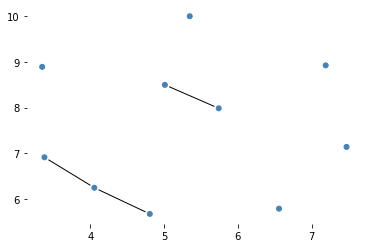

In [22]:
sample_graph = graphs_dict["10_nodes__0.1_probability"]["graphs"][4]
layout = sample_graph.layout(layout='circle')

fig, ax = plt.subplots()
ig.plot(sample_graph, target=ax)

sns.despine(left = True, bottom = True)

As the probability is increasead, the connectivity can be observed.

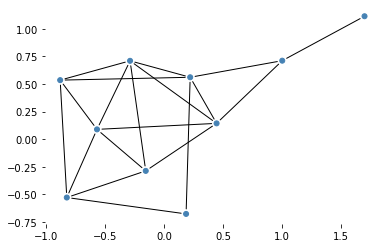

In [23]:
sample_graph = graphs_dict["10_nodes__0.5_probability"]["graphs"][4]
layout = sample_graph.layout(layout='circle')

fig, ax = plt.subplots()
ig.plot(sample_graph, target=ax)

sns.despine(left = True, bottom = True)

## Extract the giant components and characterize them

In [13]:
sample_graph = graphs_dict["10_nodes__0.1_probability"]["graphs"][4]

In [14]:
sample_graph.transitivity_local_undirected()

[0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [15]:
giant = sample_graph.clusters().giant()

In [16]:
layout = sample_graph.layout(layout='circle')

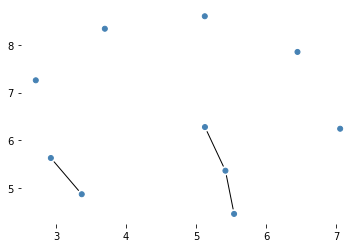

In [17]:


fig, ax = plt.subplots()
ig.plot(sample_graph, target=ax)

sns.despine(left = True, bottom = True)

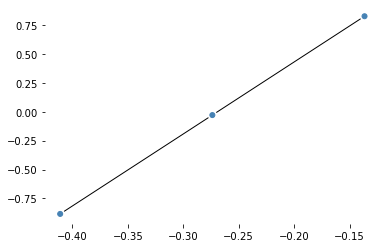

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ig.plot(giant, target=ax)

sns.despine(left = True, bottom = True)

In [19]:
cl = sample_graph.clusters()

In [20]:
giant.get_diameter()

[1, 0, 2]

## Does the network diameter follows the logarithimic variation?